### 07. Get general statistics.

---
1. Number of days players played the game
* Number of matches played by date
* Number of cheaters by ban date
* Number of cheaters per match (Consider only the matches where at least one cheater played.)

In [1]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read telemetry data stored in my S3 bucket.
spark.read.parquet("s3://social-research-cheating/raw_td.parquet").createOrReplaceTempView("td")

# Read a table that contains player data.
spark.read.parquet("s3://social-research-cheating/nodes.parquet").createOrReplaceTempView("players")

# Read a table that contains cheater data.
spark.read.parquet("s3://social-research-cheating/cheater_info.parquet").createOrReplaceTempView("cheaters")

### 1. Count the number of days players played the game.

Players accessed the game for X days on average. The median value is X. 

In [ ]:
# Calculate the number of kills of each player by date.
killers = spark.sql("SELECT DISTINCT src AS id, m_date, FROM td")
killers_df = killers.toPandas()

# Calculate the number of deaths of each cheater by date.
victims = spark.sql("SELECT DISTINCT dst AS id, m_date, FROM td")
victims_df = victims.toPandas()

temp_kills = killers_df[['id', 'm_date']]
temp_deaths = victims_df[['id', 'm_date']]
temp = pd.concat([temp_kills, temp_deaths])
temp = temp.drop_duplicates(subset=['id', 'm_date'])

temp = spark.createDataFrame(temp)
temp.registerTempTable("temp")
days = spark.sql("SELECT id, COUNT(*) AS days FROM temp GROUP BY id")

# Store the table in the S3 bucket for the later use (plotting general statistics).
days.write.parquet("s3://social-research-cheating/general-stats/num_of_days.parquet")

In [ ]:
# Calculate the mean and median number of days.
days_df = days.toPandas()

print(days_df['days'].mean())
print(days_df['days'].median())

In [ ]:
# Plot the distribution of days players played the game.
bins = np.arange(0, days_df['days'].max() + 1.5) - 0.5
fig = days_df.hist(column = 'days', histtype='step', 
                   weights=np.zeros_like(days_df['days'])+1./len(days_df['days']), 
                   bins = bins)
plt.xlim(xmin=0.5)
plt.xlim(xmax=31)
plt.xlabel("Number of days players played the game")
plt.ylabel("Proportion")
plt.title("")
plt.tight_layout()
plt.show()
fig.savefig('figs/general_stats/num_of_days.png')

### 2. Count the number of matches by date.

In [ ]:
# Read the data stored in the S3 bucket and convert it into a dataframe.
PATH_TO_DATA = "s3://social-research-cheating/general-stats/mids_by_date.parquet"
mids_by_date = spark.read.parquet(PATH_TO_DATA)
mids_by_date_df = mids_by_date.toPandas()

mids_by_date_df['m_date'] = pd.to_datetime(mids_by_date_df['m_date'], format='%Y-%m-%d')
mids_by_date_df.set_index(['m_date'], inplace=True)

# Plot a line chart.
fig = plt.plot(mids_by_date_df.index, mids_by_date_df['num_of_mids'], 
               color='blue', linestyle='solid')
plt.xlim(xmin=1)
plt.xlim(xmax=31)
plt.ylim(xmin=10000)
plt.xlabel("Date")
plt.ylabel("Number of matches")
plt.tight_layout()
plt.show() 
fig.savefig('figs/general_stats/num_of_matches_by_date.png')

In [ ]:
# Count the total number of matches.
# The answer should be 1,146,941.
print(mids_by_date_df['num_of_mids'].sum())

### 3. Count the number of cheaters by ban date.

In [ ]:
# Read the data stored in the S3 bucket and convert it into a dataframe.
PATH_TO_DATA = "s3://social-research-cheating/general-stats/num_of_cheaters.parquet"
num_of_cheaters = spark.read.parquet(PATH_TO_DATA)
num_of_cheaters_df = num_of_cheaters.toPandas()

num_of_cheaters_df['m_date'] = pd.to_datetime(num_of_cheaters_df['m_date'], format='%Y-%m-%d')
num_of_cheaters_df.set_index(['m_date'], inplace=True)

# Plot a line chart.
fig = plt.plot(num_of_cheaters_df.index, mids_by_date_df['num_of_mids'], 
               color='blue', linestyle='solid')
plt.xlim(xmin=1)
plt.xlim(xmax=31)
plt.xlabel("Date")
plt.ylabel("Number of banned cheaters")
plt.tight_layout()
plt.show() 
fig.savefig('figs/general_stats/num_of_cheaters_by_ban_date.png')

In [ ]:
# Count the total number of cheaters.
# The answer should be 6,161.
print(num_of_cheaters_df['num_of_mids'].sum())

### 4. Count the number of cheaters per match.

In [4]:
# Read the logs of the matches where at least one cheater took part in.
PATH_TO_DATA = "s3://social-research-cheating/obs_mech_data.parquet"
data_with_cheaters = spark.read.parquet(PATH_TO_DATA)
data_with_cheaters.registerTempTable("data_with_cheaters")

# First, get a list of participants.
participants = spark.sql("""SELECT mid, m_date, dst AS id FROM td GROUP BY mid, m_date, dst 
                            UNION SELECT mid, m_date, src FROM td GROUP BY mid, m_date, src 
                            ORDER BY mid""")
participants.registerTempTable("participants")

# Get a node table that contains the start date of cheating for each cheater.
nodes = spark.sql("""SELECT t.id, t.pname, CASE WHEN c.start_date IS NULL THEN 0 ELSE 1 END AS cheating_flag, 
                     CASE WHEN c.start_date IS NULL THEN 'NA' ELSE c.start_date END AS start_date, 
                     CASE WHEN c.ban_date IS NULL THEN 'NA' ELSE c.ban_date END AS ban_date 
                     FROM td_nodes t LEFT JOIN cheaters c ON t.id = c.id""")
nodes.registerTempTable("nodes")

# Add cheating flags of cheaters.
players_with_cheater_info = spark.sql("""SELECT mid, m_date, p.id, 
                                         CASE WHEN m_date >= start_date AND cheating_flag = 1 THEN 1 ELSE 0 END AS flag 
                                         FROM participants p JOIN nodes n ON p.id = n.id ORDER BY mid, flag""")
display(participants_with_cheater_info)
players_with_cheater_info.registerTempTable("players_with_cheater_info")

# Calculate the number of cheaters per match.
num_of_cheaters = spark.sql("""SELECT mid, cheater_cnt 
                               FROM (SELECT mid, SUM(flag) AS cheater_cnt FROM players_with_cheater_info GROUP BY mid) 
                               WHERE cheater_cnt >= 1""")
num_of_cheaters.registerTempTable("num_of_cheaters")

14416

In [ ]:
print(num_of_cheaters.count())
num_of_cheaters.show(10)
num_of_cheaters_df = num_of_cheaters.toPandas()

In [ ]:
# Plot the distribution of the number of cheaters per match.
bins = np.arange(0, num_of_cheaters_df['cheater_cnt'].max() + 1.5) - 0.5
fig = num_of_cheaters_df.hist(column = 'cheater_cnt', histtype='step', bins=bins, 
                              weights=np.zeros_like(num_of_cheaters_df['cheater_cnt'])+1./len(num_of_cheaters_df['cheater_cnt']))
plt.xlim(xmin=0)
plt.xlabel("Number of cheaters per match")
plt.ylabel("Proportion")
plt.title("")
plt.show()
fig.savefig('figs/general_stats/num_of_cheaters_per_match.png')

# Count the number of matches where only one cheater took part in.
print(len(num_of_cheaters_df[num_of_cheaters_df['cheater_cnt'] == 1]))

### Create a visualization of a match.

In [42]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
edges = pd.read_csv("data/viz/edge_list.csv")
edges['time'] = pd.to_datetime(edges['time'])
edges = edges.sort_values(['time']).reset_index(drop=True)
print(edges.head())

                                        src  \
0  account.16373fa7e1c144edaced3e3d20f5e4c7   
1  account.ce3501cda3af48e1aa1543b265307408   
2  account.2f3f23f43fb4429a852c57b8131db638   
3  account.bdd1510da5a8432da178e6bc4e4c0a5f   
4  account.16373fa7e1c144edaced3e3d20f5e4c7   

                                        dst                             time  \
0  account.fb7d3cfc84bc495397401f58cd75a9d2 2019-03-02 18:59:28.908000+00:00   
1  account.d6ed12eb92824fc1852d76f2ab6c6036 2019-03-02 18:59:30.250000+00:00   
2  account.b1424f2d9df644d799d837112602989d 2019-03-02 18:59:53.407000+00:00   
3  account.a7230ce441f14ab988fc2f85dfdb0d95 2019-03-02 18:59:55.635000+00:00   
4  account.63220a11bddf4ce0b78fc9628eb0109d 2019-03-02 18:59:58.783000+00:00   

       m_date  
0  2019-03-02  
1  2019-03-02  
2  2019-03-02  
3  2019-03-02  
4  2019-03-02  


In [23]:
g = nx.from_pandas_edgelist(edges, 'src', 'dst', True, nx.MultiDiGraph())

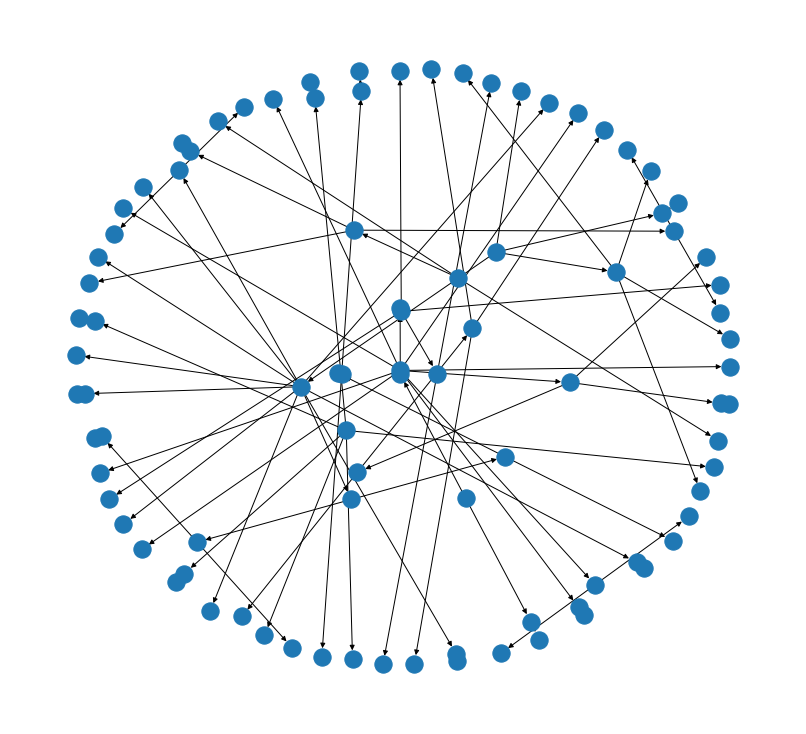

In [65]:
fig = plt.figure(figsize=(11, 10))
nx.draw(g, with_labels=False, node_size=300, pos=nx.spring_layout(g, k=0.3, iterations=500))
plt.show()